In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mripng:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1391014%2F2306275%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240321%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240321T134756Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51a52f9a1ae28f4ef12d393b715351081b8ff5abd884e0e9a9fdd9fc6b9346f241c2a401c86d6920a54f9c159e92a45ee7fdc9996ce5b5de14e978d57f4c815f20dbfb332ae83a673bd5e7d455969d84f0a2a8988460d1939b72cfe91a12fee81e72937342509eff7b874398425b1a2f949c39389d60f44e90cc0fb331c8adaf6fb6cc3a81a46ef80431763200484f41b527849d955ef067d80e426e917c0b5d3248a55c65919880b23c74f377ddbe5e4b7035a5adf1128dfe2b8d03608fb07ecd6871b637812d99d78bb3137ee4c99e3ebd2cda5f2811d2829b5e191c86fdb95466d5197ee3cc373cd6ca90454c9a2e54f7ac9f003059c6c6359a25a6d0221d,ctpng:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1391016%2F2306280%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240321%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240321T134756Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D289d2c208d242b4ebb5ffc045190fcaaf6650df4f39542ba832441f3c4b807aee57878ef32f40783d9e38e5065a4731167e9fc2b5758c748c3f5850eaa85e08e1f784c8f4cba0e9930741bfe262ea38f07c956d4b6e7ee3e1ef6aeaea6720d8e3705e40f3065b8a371dac405f5d63d5d4dabb5db16e05944136eab62ba991ea25406573cbefc40bd190dd14cc818541b27b6248f177c647ec3e1b84a960a7ebb41d6ab9665cb32d045d8950fe5c71ef7ef6a4127db374f62d40dd4652e6a0914be68238b942dff8a734540757155b2ecd7d4bbecd03fa7cff13c701c3c816cef4ef093798591a51a6c59a9468963ec170f31dfd153be940ea1f38f15f2a657c6,mri2ct/other/mr2ct/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F14357%2F17236%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240321%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240321T134756Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D428219d2b164b7f6745f336c8395ad8e07ce59f5a789c5fca1f6b732a8f0662006d636a30c0c8ddd8ca627a7304ddadecdcad7a82c8ee57f9045b596547ad6d658bd24041217df87758bebcd4dca8a549a7df12e9d8149a6a886973dc18e19d45c69f1bb49f36259429acd814978824485a543d55bfedce55dc3883048ffe9be069b14597170bb1ffb95ddb495feced8976123f63f465a55e0a25b7cb87e363a038c4b9c6706a643748ad9c65f5b758fac34b5ef380f33c8657b2fb9df7edbc9bc57727bc264ac64b203fbd7f5e8c07c8deefa8da4f61365291ea1a4992828b87a2f3a8c43f882c911a85fc7bb13a53b1f2661899039540e85845abfa44c32a7,ct2mr/other/v1.2/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F14366%2F17250%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240321%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240321T134756Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2d46f464aaea17f09be4a87b0f58f8677a45657beca8f37ba32668339e75b1eb214dcd9d3ce60a306565ad75e098c425245737150734435a9ac4e44ab8c3546a17cc20bd58b2f22168832e6f7394a3512e33cf701227334ab8256fbcdfb42edb5aaf64e69f907143101c358d781d6ebfa422cf0ab6d5f1bf544ccce7c20dea667354d5810294f05b8c73cd02e930c9293450254d3eaa771a53fc4ee672575265e608452685adddc8d4568a23fde7c7badf612c4bac690eae7fb4b1e91bbfa178bcba07f0394a7cc6b57ce4ad3ecb2589c490b43e65234998b29f6702e246c47d523cbfcf812c3872bbcfa338879d69cc1e390c07ca883f6008f376aa35176b36,v2-a2b/other/v1/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F15341%2F18483%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240321%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240321T134756Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0524bcf8e0b4a85caccdec81e177ef99466f0ab9ff8ce3c4f054ff0afe329ef0d00e139585e845af7304234a46cd96ab18c0f2f7b2664ff864fb4799a68cffd8ff4c8191b7f06815700a3d0bd4eebd5094936bf605e57648e197a2e79026d44fb7b9cd80084bdee461d885beb3ea6aed0d19b2f729229d6bad71efdcae300dfa59a912730e0d61b9543347622869f4a97b5472245d3a4f539a38222e80b02082ed3b75608a45fea0b3d842a4a4dd54b4f71272e6cd35a5b45cd7a8c296b62d4779c27deed4c1b55b0ced971365037cdc380625efb05aa593910fa2617eaf67cc5d681f346a7afb17dca23a9786211a036fb82a4ecb002256d2f9975b6a0945ef,v2-b2a/other/v2/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F15344%2F18486%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240321%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240321T134756Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db9416c6d5607111ff04d75f381ef3ea90c488fe0a3f2d4afad8b2a8a7ee7e7077b21b5764080afd1cd98daed50a98f99ac9a9ac5861904c143c31fa92baf9870bb5314820a5f15c3065d39703fd17943631762c98fb6333d31f82a23c9076ee53f822563f4b16f3d873d190f835704298868b306d3bcdabf8a624e5a1dec7844e6d80b81b6b0be070271351107c6132caac865f6c60ed464d28fef8e4d42f64865aa1fe35364d0cda4a1e47ebe733781063254e195b00256f0eab2255961e14c5230ba01bc2af7ad7e42554ac993000e7b10ff1a45340c350a6846139dc3df15c6a6b589a82b5b4baf287ba27962484a0c08f40eac30685a746c715e34455829'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
#folder 1- mri:300 images into 3 folds (3 subfolders)of 140,110,50 images respectively.
#folder 2- mri:300 images into 3 folds (3 subfolders)of 140,110,50 images respectively.

In [ ]:
# preparing the mri and ct dataset
from os import listdir
from numpy import asarray
from PIL import *
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
# load dataset A
'''
path = '../input/mrbraintrainpng/'
dataA1 = load_images(path + 'trainMRI/')
path = '../input/mrbraintestpng/'
dataAB = load_images(path + 'testMRI/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
path = '../input/ctbraintraindatapng/'
dataB1 = load_images(path + 'trainCT/')
path = '../input/ctbraintestpng/'
dataB2 = load_images(path + 'testCT/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
'''

#####################################################   first fold as test set  ##################################
# dataset path for mri images
path = '../input/mripng/MRI/'
# load dataset A
data1 = load_images(path + 'fold1/')
data2 = load_images(path + 'fold2/')
dataA1 = vstack((data1, data2))#trainMRI
dataAB = load_images(path + 'fold3/')#testMRI
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)

# dataset path for ct images
path = '../input/ctpng/CT/'
# load dataset A
data1 = load_images(path + 'fold2/')
data2 = load_images(path + 'fold3/')
dataB1 = vstack((data1, data2))#trainCT
dataB2 = load_images(path + 'fold1/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)

# save as compressed numpy array
filename = 'mri2ct_256_f1.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)


Loaded dataA:  (300, 256, 256, 3)
Loaded dataB:  (300, 256, 256, 3)
Saved dataset:  mri2ct_256_f1.npz


Loaded:  (300, 256, 256, 3) (300, 256, 256, 3)


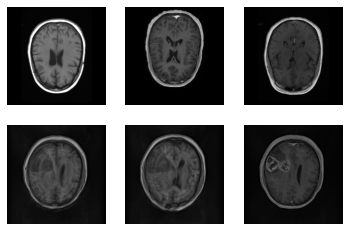

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('mri2ct_256_f1.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ssuz_dj4
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ssuz_dj4
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101064 sha256=5cb66583f8b7e17abb29a061cf2814679b4740e9eed83ac266039ad497895a9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ioprm91r/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)


In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=1):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 60, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:

			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
# example of training a cyclegan on the mri2ct dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 60, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

# load image data
dataset = load_real_samples('mri2ct_256_f1.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (300, 256, 256, 3) (300, 256, 256, 3)
>1, dA[1.276,0.764] dB[1.841,0.653] g[23.740,23.759]
>2, dA[18.614,1.201] dB[5.478,3.876] g[24.617,28.160]
>3, dA[2.977,1.189] dB[8.084,5.038] g[22.167,22.353]
>4, dA[1.904,1.936] dB[1.732,6.207] g[22.566,22.935]
>5, dA[1.542,3.013] dB[0.627,1.973] g[22.382,23.794]
>6, dA[0.488,2.488] dB[0.479,1.679] g[20.490,21.876]
>7, dA[0.454,2.783] dB[0.427,1.079] g[19.896,21.826]
>8, dA[0.509,2.392] dB[0.338,0.524] g[19.645,21.272]
>9, dA[0.408,2.487] dB[0.295,0.348] g[19.162,21.184]
>10, dA[0.313,0.927] dB[0.334,0.447] g[18.139,19.055]
>11, dA[0.282,0.320] dB[0.198,0.493] g[19.074,19.370]
>12, dA[0.267,0.413] dB[0.376,0.247] g[18.537,19.231]
>13, dA[0.249,0.418] dB[0.277,0.237] g[18.845,19.465]
>14, dA[0.281,0.889] dB[0.252,0.223] g[17.621,18.153]
>15, dA[0.368,1.052] dB[0.270,0.277] g[18.590,19.496]
>16, dA[0.485,0.578] dB[0.210,0.349] g[16.575,17.423]
>17, dA[0.742,0.403] dB[0.236,0.243] g[17.661,17.721]
>18, dA[0.888,1.040] dB[0.154,0.175] g[18.358

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

In [ ]:
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/kaggle/input/v2-a2b/other/v1/1/g_model_AtoB_018060.h5', cust)
model_BtoA = load_model('/kaggle/input/v2-b2a/other/v2/1/g_model_BtoA_018060.h5', cust)

In [ ]:
import os

def count_files(directory):
	count = 0
	for root, dirs, files in os.walk(directory):
		for name in files:
			count += 1
	print(count)

count_files('../input/mripng/MRI/fold1')

210


SSIM:0.8189963102340698
MSE: 24.545613606770832
PSNR: 34.23106467528224


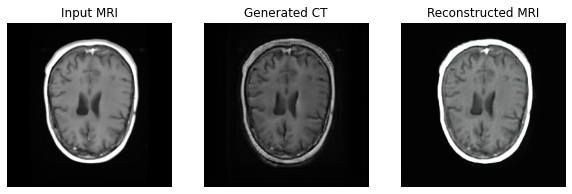

In [ ]:
# load the image
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2
import math

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

image_A = load_image('../input/mripng/MRI/fold1/op-op-3363-1-17 (35).png')

# translate image
image_A2B = model_AtoB.predict(image_A)
image_B2A = model_BtoA.predict(image_A2B)

# scale from [-1,1] to [0,1]
image_A = (image_A + 1) / 2.0
image_A2B = (image_A2B + 1) / 2.0
image_B2A = (image_B2A + 1) / 2.0

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)
plt.imshow(image_A[0])
plt.axis('off')
plt.title("Input MRI")

fig.add_subplot(1, 3, 2)
# showing image
plt.imshow(image_A2B[0])
plt.axis('off')
plt.title("Generated CT")

fig.add_subplot(1, 3, 3)
# showing image
plt.imshow(image_B2A[0])
plt.axis('off')
plt.title("Reconstructed MRI")

plt.imsave('image_A.png',image_A[0])
plt.imsave('image_A2B.png',image_A2B[0])
plt.imsave('image_B2A.png',image_B2A[0])

path1 = './image_A.png'
path2 = './image_B2A.png'

im1 = tf.image.decode_image(tf.io.read_file(path1))
im2 = tf.image.decode_image(tf.io.read_file(path2))

ssim1 = float(tf.image.ssim(im1, im2, max_val=255, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03))

img1 = cv2.imread(path1)
img2 = cv2.imread(path2)

mse1 = np.square(np.subtract(img1,img2)).mean()
psnr1 = psnr(img1,img2)


print("SSIM:" + str(ssim1))
print("MSE:",mse1)
print("PSNR:",psnr1)
print("====================")

In [ ]:
# function to calculate average ssim over test set
ssim_list = []
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)
mse1 = np.square(np.subtract(img1,img2)).mean()
psnr1 = psnr(img1,img2)
def average_eval(test_folder):
	count = 0
	ssim_total = 0.0
	psnr_total = 0.0
	mse_total = 0.0
	for root, dirs, files in os.walk(test_folder):
		for name in files:
			count += 1
			image_A = load_image(os.path.join(root, name))
			image_A2B = model_AtoB.predict(image_A)
			image_B2A = model_BtoA.predict(image_A2B)
			image_A = (image_A + 1) / 2.0
			image_A2B = (image_A2B + 1) / 2.0
			image_B2A = (image_B2A + 1) / 2.0
			plt.imsave('image_A.png',image_A[0])
			plt.imsave('image_A2B.png',image_A2B[0])
			plt.imsave('image_B2A.png',image_B2A[0])
			path1 = './image_A.png'
			path2 = './image_B2A.png'
			im1 = tf.image.decode_image(tf.io.read_file(path1))
			im2 = tf.image.decode_image(tf.io.read_file(path2))
			ssim = tf.image.ssim(im1, im2, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
			ssim_total += float(ssim)
			ssim_list.append(float(ssim))
			img1 = cv2.imread(path1)
			img2 = cv2.imread(path2)
			mse_val = np.square(np.subtract(img1,img2)).mean()
			psnr_val = psnr(img1,img2)
			mse_total += mse_val
			psnr_total += psnr_val
			break
	print("Average SSIM:",ssim_total/count)
	print("Average PSNR:",psnr_total/count)
	print("Average MSE:",mse_total/count)

average_eval('../input/mripng/MRI/fold2')
#print(ssim_list)

Average SSIM: 0.7169255614280701
Average PSNR: 30.892168827881513
Average MSE: 52.94969685872396
